In [1]:
# if needed, set your working directory to the course example folder
import os
os.chdir(os.path.expanduser('~/scalable-computing-examples'))

In [2]:
# Set up imports
import pandas as pd
import numpy as np
import xarray as xr

import gcsfs
import fsspec
import zarr

### Create a Zarr dataset

Set a path to serve as the root of the Zarr storage hierarchy, and create a root-level group. Verify that something happened to create `data/example.zarr` on the local file system.

In [104]:
store = zarr.DirectoryStore('data/example.zarr')
root = zarr.group(store=store, overwrite=True)

Now add two Zarr groups called `temp` and `precip`. We haven't added any data yet! But what changes on the file system?

In [105]:
root.create_group('temp')
root.create_group('precip')

<zarr.hierarchy.Group '/precip'>

Next, in the `temp` group, let's define a dataset called `t100`. We'll specify the overall shape of this array, the chunk sizes, the data type, and a fill value for missing data ... but no actual data yet! What does this create under `data/example.zarr` on the file system?


In [106]:
root.temp.create_dataset('t100',
                         shape=(10000, 10000),
                         chunks=(1000, 1000),
                         dtype='i4',
                         fill_value=99,
                         overwrite=True)

<zarr.core.Array '/temp/t100' (10000, 10000) int32>

In [107]:
# Index on the first 5 rows and columns. Does it look like what you expect? Explain!
root.temp.t100[:5, :5]

array([[99, 99, 99, 99, 99],
       [99, 99, 99, 99, 99],
       [99, 99, 99, 99, 99],
       [99, 99, 99, 99, 99],
       [99, 99, 99, 99, 99]], dtype=int32)

Within our Python session, now let's create a 10,000 x 10,000 Zarr array of all 1's, specifying a 1K by 1K chunk size. To make it a little more interesting, let's replace the first row to the sequence 0...999. Note that this array only exists in memory for now.

In [108]:

precip = zarr.ones(shape=(10000, 10000),
                   chunks=(1000, 1000),
                   dtype='i4')
precip[0, :] = np.arange(10000)

In [109]:
# Index on the first 5 rows and columns. Does it look like what you expect?
precip[:5, :5]

array([[0, 1, 2, 3, 4],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=int32)

Now let's add this precip array to our file-based Zarr store, with the name `p100`. Then look again at the file system. What do you now see under the precip group?

In [110]:
root.precip['p100'] = precip

Zarr objects in Python have a useful `.info()` method that you can use to retrieve useful operational details about the array (or group). Use this on the stored `t100` and `p100` arrays, as well as your in-memory `precip` array, and consider what it tells you.

In [ ]:
# use the .info() method on Zarr objects

In [111]:
# Let's go back to our t100 array, and assign 10 across the last
# 3 row by 3 column subarray of the data
root.temp.t100[-3:, -3:] = 10

# ... then index on the last 5 rows and columns. Does it looks like what you expect?
root.temp.t100[-5:, -5:]

array([[99, 99, 99, 99, 99],
       [99, 99, 99, 99, 99],
       [99, 99, 10, 10, 10],
       [99, 99, 10, 10, 10],
       [99, 99, 10, 10, 10]], dtype=int32)

Now what has changed under example.zarr on the file system? Does it make sense?

For completeness, close the file store connection

In [112]:
store.close()

Lastly we can read our newly created Zarr store using the `zarr` library, and inspect the data.

In [113]:
# Use `zarr.open(<path>)` to read in your newly created Zarr store
arr = zarr.open('data/example.zarr')

In [115]:
# Try using the `tree()` method to visualize its structure
arr.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='precip', nodes=(Node(disabled=True,…

In [116]:
# Does the precip/p100 array look like what you created?
arr.temp.t100[-5:, -5:]

array([[99, 99, 99, 99, 99],
       [99, 99, 99, 99, 99],
       [99, 99, 10, 10, 10],
       [99, 99, 10, 10, 10],
       [99, 99, 10, 10, 10]], dtype=int32)

### Retrieve CMIP6 data from a remote Zarr store

We'll start out by reading a CSV file that catalogs all the available CMIP6 Zarr stores in this Google Cloud Storage account.

In [117]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [118]:
# Each row identifies a Zarr stores. How many are there in total?
len(df)

523774

In [119]:
# What do the first few rows look like?
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


Next let's use pandas to select CMIP zstore records corresponding to a simulation of the recent past (`historical`) from the ocean daily (`Oday`) table, focusing on the sea surface height (`tos`) variable. We’ll also only select results from the NOAA Geophysical Fluid Dynamics Laboratory (`NOAA-GFDL`) runs.

In [120]:
df_ta = df.query("""
    activity_id=='CMIP' &
    table_id == 'Oday' &
    variable_id == 'tos' &
    experiment_id == 'historical' &
    institution_id == 'NOAA-GFDL'
    """.replace('\n', ''))
df_ta

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9445,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Oday,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
9446,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
244828,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726
244829,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Oday,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726


The results above are sorted in version order, so we'll just take the final record, and retrieve the Zarr store path.

In [121]:
zstore = df_ta.zstore.values[-1]
print(f'zstore: {zstore}')

zstore: gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Oday/tos/gr/v20190726/


For Zarr, we need to set up a MutableMapping interface to the storage system.

We could use the gcsfs library for this...

In [ ]:
#gcs = gcsfs.GCSFileSystem(token='anon')
#mapper = gcs.get_mapper(zstore)


But instead let's introduce `fsspec`, a useful library that abstracts over many kinds of local and remote connections. Here it detects that we're connecting to GCS, and internally uses the right implementation.


In [122]:
mapper = fsspec.get_mapper(zstore, token='anon')

Bonus: To get a quick sense of what `fsspec` supports, run these two lines in a code cell:

```python
from fsspec.registry import known_implementations
{k: v.get('class') for k, v in known_implementations.items()}
```

Now let's use xarray to reach into the Zarr store.

Note that this will use Dask by default (if Dask is installed), automagically giving us a lazy, chunked representation of the data See [the docs](https://docs.xarray.dev/en/stable/user-guide/dask.html#reading-and-writing-data) for more information.

In [123]:
ds = xr.open_zarr(mapper)

In [124]:
# Have a look at the ds dataset, and specifically the 'tos' data array
# Notice the dimensionality and size.
ds

<xarray.Dataset> Size: 16GB
Dimensions:    (lat: 180, bnds: 2, lon: 360, time: 60225)
Coordinates:
  * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 3kB dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bnds   (lon, bnds) float64 6kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
    time_bnds  (time, bnds) object 964kB dask.array<chunksize=(30113, 1), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tos        (time, lat, lon) float32 16GB dask.array<chunksize=(374, 180, 360), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    title:                  NOAA GFDL GFDL-ESM4 model output prepared for CMI...
    tracking_id:            hdl:21.14100/a5569126-1a36-4212-947e-ae7c9cc237e5
    variable_id:            tos
    variant_info:           N/A
    variant_label:          r1i1p1f1
    version_id:             v20190726

In [125]:
# Select a tiny piece of the data, taking a lat slice of 71 to 73,
# lon slice of 203 to 205, and time slice of 2010 to 2012
tos_subset = ds.tos.sel(lat=slice(71, 73),
                        lon=slice(203, 205),
                        time=slice('2010', '2012'))

# How big is this subset of data?
tos_subset

<xarray.DataArray 'tos' (time: 1095, lat: 2, lon: 2)> Size: 18kB
dask.array<getitem, shape=(1095, 2, 2), dtype=float32, chunksize=(374, 2, 2), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 16B 71.5 72.5
  * lon      (lon) float64 16B 203.5 204.5
  * time     (time) object 9kB 2010-01-01 12:00:00 ... 2012-12-31 12:00:00
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Sea Surface Temperature
    original_name:  tos
    standard_name:  sea_surface_temperature
    units:          degC

Next let's create a pair of smaller summary datasets, first taking the mean for each day across our returned spatial grid cells, and then taking a 90-day rolling mean over the daily time series.

Importantly, note that because we're working with Dask arrays, these are all lazy computations! We haven't loaded any data yet.

In [126]:
daily_sst = tos_subset.mean(dim=('lat', 'lon'))
rolling_90d_sst = daily_sst.rolling(time=90, center=True).mean()

Now let's generate a plot, which will force execution and therefore loading of actual data

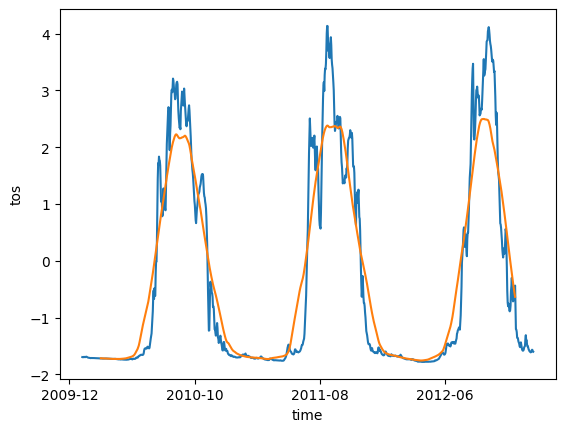

In [127]:
daily_sst.plot(label="daily")
rolling_90d_sst.plot(label="rolling annual mean")

As an exercise, you can try adding `.load()` at the end of the assignments above where we first calculated the daily mean and rolling mean, then try plotting again. Notice the speedup in plotting after we've pre-loaded the data in `daily_sst` and `rolling_90d_sst`. In this case, because those summary datasets are so small, this is safe and convenient, especially if we end up re-plotting many times to get the aesthetic details right.

Lastly, let's try writing our small dataset out to a local Zarr store, just to see what it looks like on disk, then read it back in to verify everything is there.

In [132]:
# Write our original subset out to a local Zarr store
tos_subset.to_zarr('data/cmip_tos_subset.zarr', safe_chunks=False, consolidated=True)

# ... then open it again using xarray
xr.open_dataset('data/cmip_tos_subset.zarr')

<xarray.Dataset> Size: 26kB
Dimensions:  (lat: 2, lon: 2, time: 1095)
Coordinates:
  * lat      (lat) float64 16B 71.5 72.5
  * lon      (lon) float64 16B 203.5 204.5
  * time     (time) object 9kB 2010-01-01 12:00:00 ... 2012-12-31 12:00:00
Data variables:
    tos      (time, lat, lon) float32 18kB ...

## MUR SST

Let's do one more Zarr example, this time pulling SST data from an AWS S3 bucket. We'll use `fsspec` again. Note how similar this is to the code we used to connect to the CMIP6 data in GCS above.

One difference is that here we chose to use the generic `xr.open_dataset()` function rather than `xr.open_zarr()`. Functionally these do the same thing, but the general development trajectory for `xarray` is to favor use of the higher level `open_dataset()` function over the lower-level format-specific functions. When calling this function, we can optionally control Dask chunking using `chunks` argument; here we pass in the value `{}`, which tells `open_dataset()` to choose a chunk layout that preferred by the Zarr engine.

Note: In case your don't have `s3fs` installed in your virtual environment,
you can install it from within a Jupyter cell with the following command:
```python
!pip install s3fs
```

In [ ]:
file_location = 's3://mur-sst/zarr'

mapper = fsspec.get_mapper(file_location, anon=True)
ds_sst = xr.open_dataset(mapper, engine='zarr', consolidated=True, chunks={})

# check out the size of this Zarr array!
ds_sst

<xarray.Dataset> Size: 104TB
Dimensions:           (time: 6443, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time              (time) datetime64[ns] 52kB 2002-06-01T09:00:00 ... 2020...
Data variables:
    analysed_sst      (time, lat, lon) float64 33TB dask.array<chunksize=(6443, 100, 100), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 33TB dask.array<chunksize=(6443, 100, 100), meta=np.ndarray>
    mask              (time, lat, lon) int8 4TB dask.array<chunksize=(6443, 100, 100), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 33TB dask.array<chunksize=(6443, 100, 100), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

In [137]:
# Select a 1-D time series of the sea_ice_fraction variable array,
# extracting lat 73 and lon -157
sea_ice_ts = ds_sst.sea_ice_fraction.sel(lat=73, lon=-157)

# How big is this subset of data?
sea_ice_ts

<xarray.DataArray 'sea_ice_fraction' (time: 6443)> Size: 52kB
dask.array<getitem, shape=(6443,), dtype=float64, chunksize=(6443,), chunktype=numpy.ndarray>
Coordinates:
    lat      float32 4B 73.0
    lon      float32 4B -157.0
  * time     (time) datetime64[ns] 52kB 2002-06-01T09:00:00 ... 2020-01-20T09...
Attributes:
    comment:        ice data interpolated by a nearest neighbor approach.
    long_name:      sea ice area fraction
    source:         EUMETSAT OSI-SAF, copyright EUMETSAT
    standard_name:  sea ice area fraction
    units:          fraction (between 0 and 1)
    valid_max:      100
    valid_min:      0

Let's generate a quick time series plot of the data.

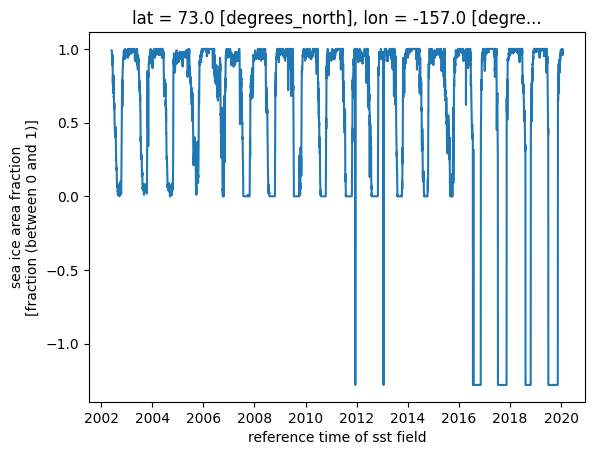

In [138]:
sea_ice_ts.plot();

In [139]:
# Now get a chunk of sea_ice_fraction for the year 2015,
# slicing on lat 72.5 to 73, and lon -157.5 to -157
sea_ice_chunk = ds_sst.sea_ice_fraction.sel(
    lat = slice(72.5, 73),
    lon = slice(-157.5, -157),
    time = '2015')

# How big is this subset of data?
sea_ice_chunk

<xarray.DataArray 'sea_ice_fraction' (time: 365, lat: 51, lon: 51)> Size: 8MB
dask.array<getitem, shape=(365, 51, 51), dtype=float64, chunksize=(365, 51, 51), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 204B 72.5 72.51 72.52 72.53 ... 72.98 72.99 73.0
  * lon      (lon) float32 204B -157.5 -157.5 -157.5 ... -157.0 -157.0 -157.0
  * time     (time) datetime64[ns] 3kB 2015-01-01T09:00:00 ... 2015-12-31T09:...
Attributes:
    comment:        ice data interpolated by a nearest neighbor approach.
    long_name:      sea ice area fraction
    source:         EUMETSAT OSI-SAF, copyright EUMETSAT
    standard_name:  sea ice area fraction
    units:          fraction (between 0 and 1)
    valid_max:      100
    valid_min:      0

Using our subset of data from 2015, calculate monthly mean sea ice fraction for all grid cells in this chunk.

In [140]:

monthly_mean_ice = sea_ice_chunk.groupby("time.month").mean()
monthly_mean_ice

<xarray.DataArray 'sea_ice_fraction' (month: 12, lat: 51, lon: 51)> Size: 250kB
dask.array<stack, shape=(12, 51, 51), dtype=float64, chunksize=(1, 51, 51), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 204B 72.5 72.51 72.52 72.53 ... 72.98 72.99 73.0
  * lon      (lon) float32 204B -157.5 -157.5 -157.5 ... -157.0 -157.0 -157.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    comment:        ice data interpolated by a nearest neighbor approach.
    long_name:      sea ice area fraction
    source:         EUMETSAT OSI-SAF, copyright EUMETSAT
    standard_name:  sea ice area fraction
    units:          fraction (between 0 and 1)
    valid_max:      100
    valid_min:      0

Our calculated monthly dataset is a small array. Let's go ahead and load it into memory. Note that `load()` turns our unevaluated Dask array into Numpy array.

In [141]:
monthly_mean_ice.load()

<xarray.DataArray 'sea_ice_fraction' (month: 12, lat: 51, lon: 51)> Size: 250kB
array([[[0.94483871, 0.94483871, 0.94483871, ..., 0.94354839,
         0.94354839, 0.94354839],
        [0.94483871, 0.94483871, 0.94645161, ..., 0.94645161,
         0.94645161, 0.94645161],
        [0.94483871, 0.94645161, 0.94645161, ..., 0.94645161,
         0.94645161, 0.94645161],
        ...,
        [0.96677419, 0.96677419, 0.96677419, ..., 0.96322581,
         0.96322581, 0.96322581],
        [0.96677419, 0.96645161, 0.96645161, ..., 0.96322581,
         0.96322581, 0.96322581],
        [0.96645161, 0.96645161, 0.96645161, ..., 0.96548387,
         0.96548387, 0.96548387]],

       [[0.9525    , 0.9525    , 0.9525    , ..., 0.94785714,
         0.94785714, 0.94785714],
        [0.9525    , 0.9525    , 0.95285714, ..., 0.95392857,
         0.95392857, 0.95392857],
        [0.9525    , 0.95285714, 0.95285714, ..., 0.95392857,
         0.95392857, 0.95392857],
...
        [0.92366667, 0.92366667, 0.92366667, ..., 0.92533333,
         0.92533333, 0.92533333],
        [0.92366667, 0.92633333, 0.92633333, ..., 0.92533333,
         0.92533333, 0.92533333],
        [0.92633333, 0.92633333, 0.92633333, ..., 0.92833333,
         0.92833333, 0.92833333]],

       [[0.96645161, 0.96645161, 0.96645161, ..., 0.96903226,
         0.96903226, 0.96903226],
        [0.96645161, 0.96645161, 0.96806452, ..., 0.97      ,
         0.97      , 0.97      ],
        [0.96645161, 0.96806452, 0.96806452, ..., 0.97      ,
         0.97      , 0.97      ],
        ...,
        [0.96645161, 0.96645161, 0.96645161, ..., 0.96870968,
         0.96870968, 0.96870968],
        [0.96645161, 0.96741935, 0.96741935, ..., 0.96870968,
         0.96870968, 0.96870968],
        [0.96741935, 0.96741935, 0.96741935, ..., 0.96806452,
         0.96806452, 0.96806452]]], shape=(12, 51, 51))
Coordinates:
  * lat      (lat) float32 204B 72.5 72.51 72.52 72.53 ... 72.98 72.99 73.0
  * lon      (lon) float32 204B -157.5 -157.5 -157.5 ... -157.0 -157.0 -157.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    comment:        ice data interpolated by a nearest neighbor approach.
    long_name:      sea ice area fraction
    source:         EUMETSAT OSI-SAF, copyright EUMETSAT
    standard_name:  sea ice area fraction
    units:          fraction (between 0 and 1)
    valid_max:      100
    valid_min:      0

Finally, let's create a faceted plot visualizing the the ice area fraction by month across our little swath of spatial grid cells

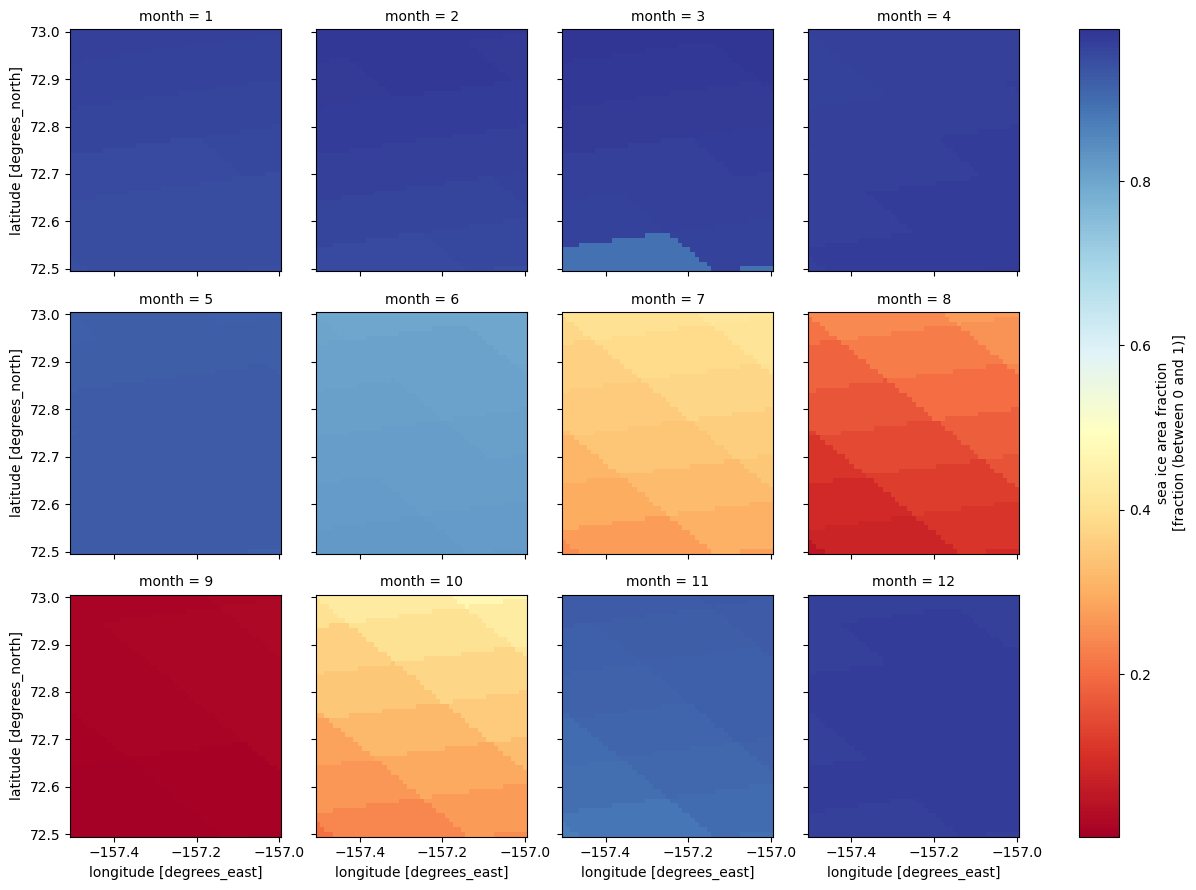

In [142]:
import matplotlib as mpl
fg = monthly_mean_ice.plot(
    col="month",
    col_wrap=4,
    cmap=mpl.cm.RdYlBu
)